In [1]:
from params import *
from pymoo.core.problem import Problem


# ptxS >= sigmaS
# Bài này tìm giá trị lớn nhất có thể đạt được của sigmaS khi cả PU và SU cùng truyền.
# Cụ thể: Khi PU xác định sẵn RbP và sigmaP (dựa trên rhoP * sigmaPmax), SU xác định sẵn RbS
#             thì giá trị lớn nhất có thể của sigmaS đạt được là bao nhiêu (khi pp và ps thay đổi)


# Feasibility Check: Giá trị sigmaS* luôn nhỏ hơn giá trị khi chỉ có SU truyền.
class TransmissionProbabilityProblem(Problem):
    def __init__(self, params: ProblemParams):
        self.P = params
        
        super().__init__(
            n_var=2,
            n_obj=1,
            n_ieq_constr=1,
            xl=np.array([0.0, 0.0]),
            xu=np.array([params.PP, params.PS]),
        )

    def _evaluate(self, x, out):
        pp, ps = x[:, 0], x[:, 1]
        out["F"] = [-self.P.ptx(pp, ps, side=Side.S)]
        out["G"] = [self.P.sigmaP - self.P.ptx(pp, ps, side=Side.P)]

    def get_output(self, result):
        if result.F == None:
            return None
        return {
            "G2.ptxSmax": -result.F[0],
            "G2.pp": result.X[0],
            "G2.ps": result.X[1],
            "G2.psmax": self.P.ptx_invert(side=Side.P)(result.X[0]),
            "G2.ppmin": self.P.gammaP * self.P.NP / (- self.P.Opp * np.log(self.P.sigmaP))
        }


In [2]:
from simulator import Simulator
from params import ProblemParams, Channel, Side, np
from generator import SampleGenerator

# Phần này sinh dữ liệu kênh truyền để phục vụ cho các bài toán sau
# Dữ liệu sinh phải đảm bảo các ràng buộc liên quan đến sigmaP, sigmaS, PPmax và PSmax
# phải có nghiệm với pp và ps

# `prob_constraints` thực hiện tìm sigmaS* =  max_{pp,ps}{sigmaS} thỏa mãn 3 ràng buộc về sigmaP, PPmax và PSmax

# Như vậy, dữ liệu kênh được chấp nhận khi và chỉ khi sigmaS*  >= sigmaS
# tức là có pp và ps thỏa mãn cả 4 ràng buộc trên.

N = 50000

# rhoS = 0.5 tức là tôi muốn sigmaS = 0.5 * sigmaSmax (bằng 1 nửa giá trị khi truyền một mình)
params = ProblemParams(
    PP=20, PS=20, NP=1, NS=1, rhoP=0.9, rhoS=0.5, R0=30, RbP=1.0, RbS=1.0
)

generator = SampleGenerator(
    params=params,
    base_generator=None,
    no_samples_per_base_item=N,
    sample_attributes=[Channel.PP, Channel.PS, Channel.SP, Channel.SS],
    sample_scale=params.R0,
    retries_per_sample=100,
    set_params_dynamic=True,
    save_all=True,
)

simulator = Simulator(
    "ptxmax",
    TransmissionProbabilityProblem,
    group="constraints",
    simulation_dir="../simulation",
    pop_size=20,
    variant="DE/rand/1/bin",
    CR=0.9,
    F=0.5,
    n_max_gen=50,
)

result_file = simulator.start(
    generator=generator,
    verbose=True,
    cache_size=min(N // 10, 5000),
    log_param_names=None,
)

print(f"RESULT AT {result_file}")


/home/vu.xuan.bac@sun-asterisk.com/b/c/final-project/src/params_problem.py:76: RuntimeWarning: divide by zero encountered in divide
  return (f * np.exp(-gamma * N / f)) / (s * gamma + f)


Success 50000/50000		Running Time: 42.62 mins
RESULT AT ../simulation/constraints/ptxmax-20240625142101/result-20240625142101.csv


In [3]:
import pandas as pd

data = pd.read_csv(result_file)

array([[<Axes: title={'center': 'G2.ptxSmax'}>]], dtype=object)

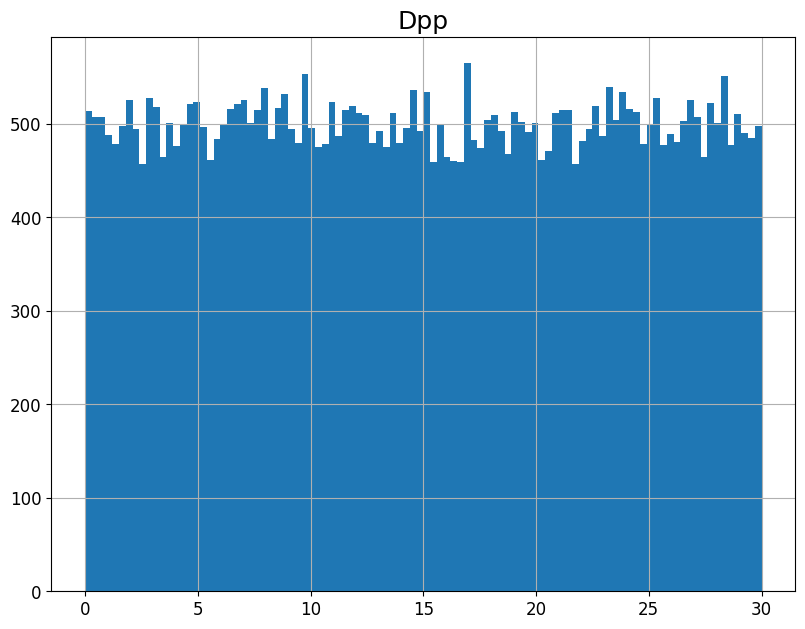

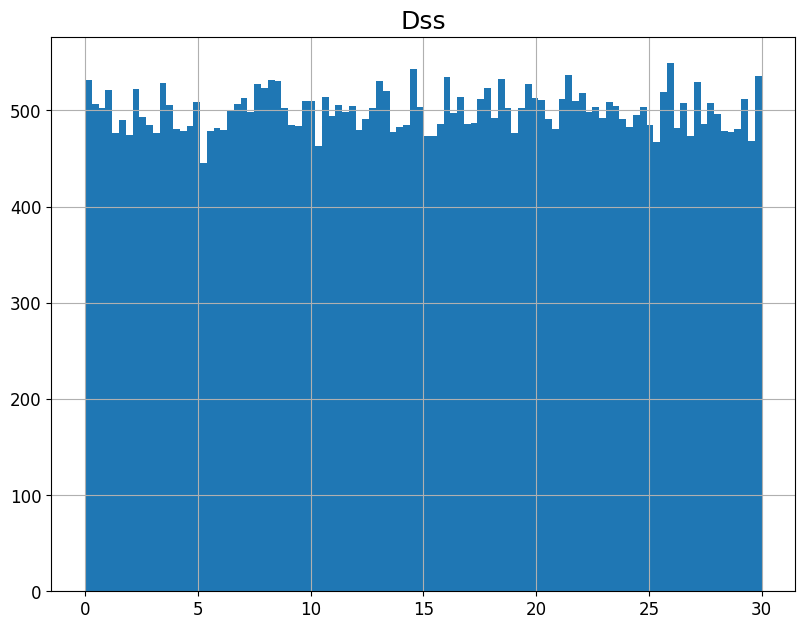

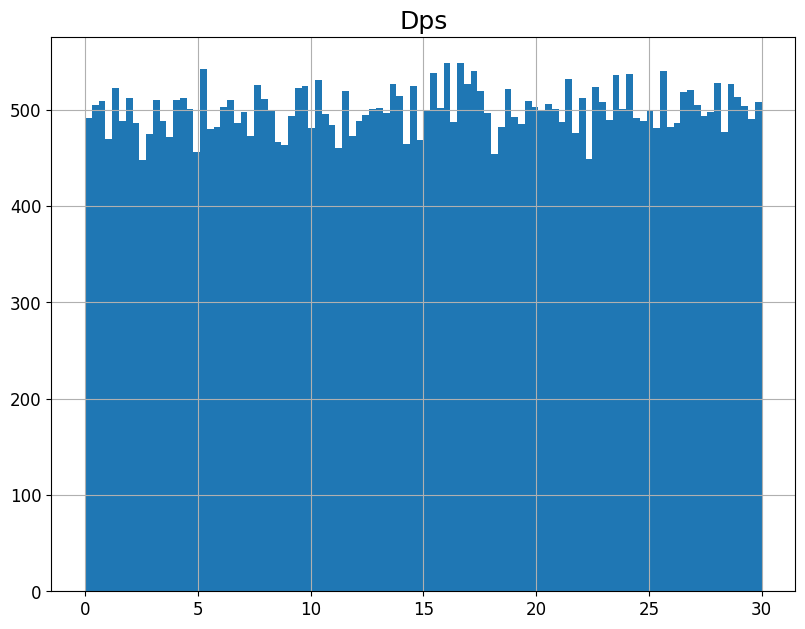

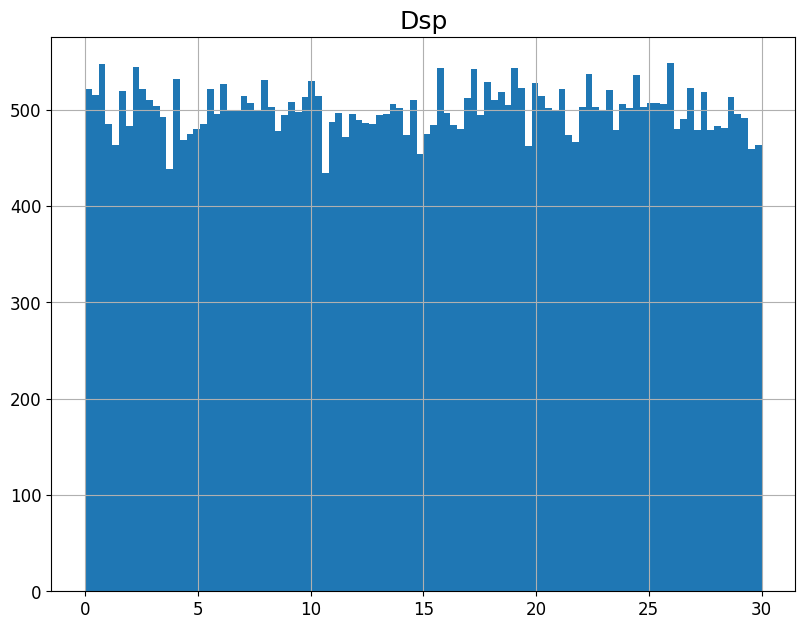

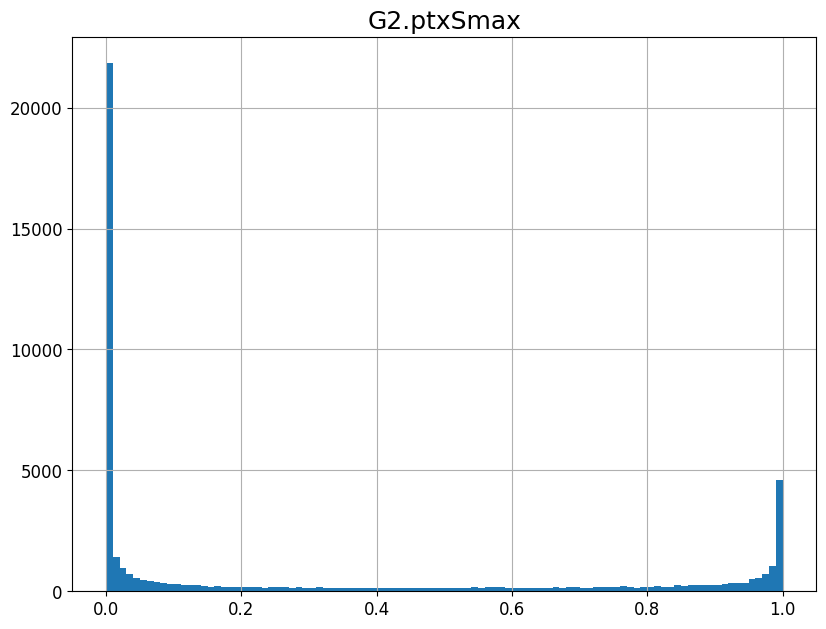

In [4]:
data.hist("Dpp", bins=100)
data.hist("Dss", bins=100)
data.hist("Dps", bins=100)
data.hist("Dsp", bins=100)
data.hist("G2.ptxSmax", bins=100, cumulative=False)

In [9]:
data[["Dpp", "Dsp", "Dss", "Dps", "G2.ptxSmax","G2.ps", "G2.pp", "G2.psmax"]].describe()

,Dpp,Dsp,Dss,Dps,G2.ptxSmax,G2.ps,G2.pp,G2.psmax
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,5.000000e+04,5.000000e+04,5.000000e+04
mean,14.990934,14.986553,15.010895,15.068580,0.319476,7.272394e+00,1.573954e+01,6.818269e+02
std,8.669930,8.655853,8.647261,8.649106,0.397555,8.452382e+00,7.294481e+00,1.310647e+05
min,0.000216,0.000409,0.000465,0.001040,0.000000,3.247847e-17,8.513966e-13,3.334907e-17
25%,7.489180,7.476231,7.584408,7.609391,0.000002,1.930126e-01,1.432114e+01,1.935980e-01
50%,14.944052,15.078745,15.018852,15.140806,0.041798,2.212729e+00,1.999856e+01,2.213464e+00
75%,22.566976,22.477052,22.466315,22.576694,0.733985,1.997369e+01,1.999993e+01,1.998174e+01
max,29.999735,29.999729,29.997668,29.998650,1.000000,2.000000e+01,2.000000e+01,2.894918e+07


array([[<Axes: title={'center': 'G2.ps'}>]], dtype=object)

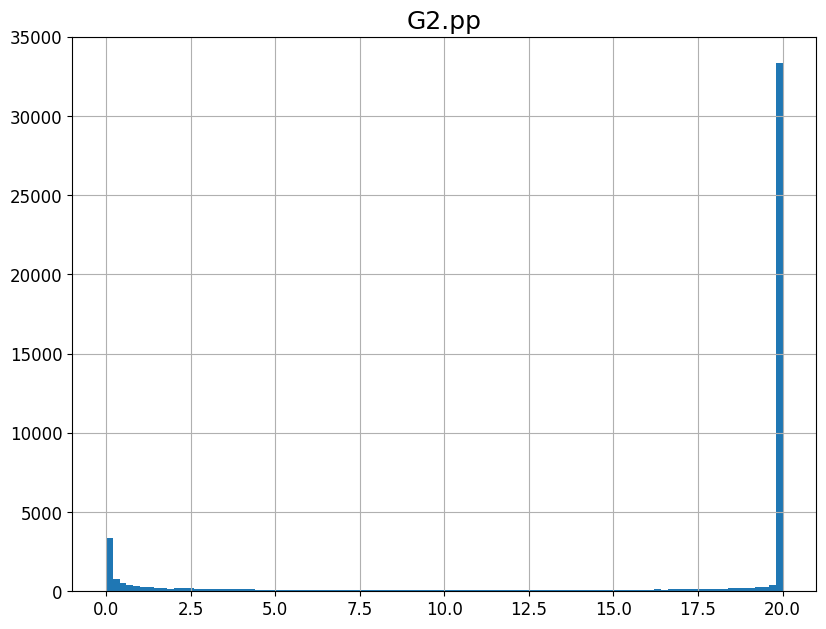

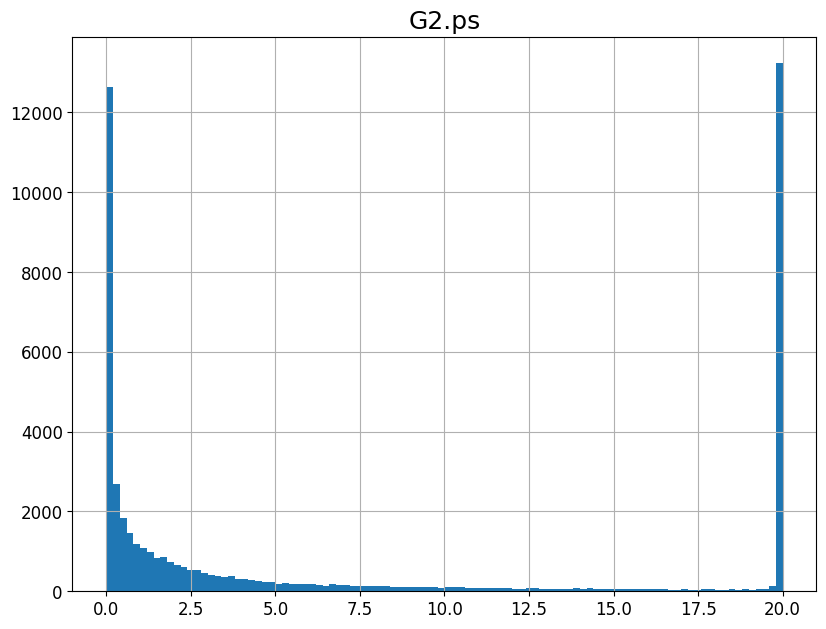

In [6]:
data.hist("G2.pp", bins=100)
data.hist("G2.ps", bins=100)
